In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import rasterio

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/Repos/observatorio-ciudades/accesibilidad-urbana/aup/data.py:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


In [2]:
from scipy.stats import mode 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

# save output to database?
save = False
# How to save?
if_exists='append'
# save to local?
save_local = True
# use local data?
local_data = True
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

In [5]:
# 'alex' or 'edgar'
all_local_dirs = 'edgar'
# Output hexs resolution
res = 10
# Area of analysis
area_of_analysis = 'zona_censal' # zona_censal, hexagonos, unidades_vecinales
# Persona speed
walk_speed = 4.5
speed_name = str(walk_speed).replace('.','_')

In [6]:
if all_local_dirs == 'alex':
    grl_dir = "../../../data/external/temporal_todocker/santiago/proximidad/"
elif all_local_dirs == 'edgar':
    grl_dir = "../../../data/processed/santiago/"
else:
    print("WARNING: Fix all_local_dirs variable")

In [7]:
if area_of_analysis == 'zona_censal' and local_data:
    gdf = gpd.read_file(grl_dir + f'santiago_zonascensalesanalysis_{speed_name}_kmh.geojson')

elif area_of_analysis == 'zona_censal' and not local_data:
    table = f'santiago_zonascensalesanalysis_{speed_name}_kmh'
    schema = 'projects_research'
    gdf = aup.gdf_from_db(table, schema)

elif area_of_analysis == 'unidades_vecinales' and local_data:
    gdf = gpd.read_file(grl_dir + f'santiago_unidadesvecinales_hqsl_{speed_name}_kmh.gpkg')

elif area_of_analysis == 'unidades_vecinales' and not local_data:
    table = f'santiago_unidadesvecinalesanalysis_{speed_name}_kmh'
    schema = 'projects_research'
    gdf = aup.gdf_from_db(table, schema)

elif area_of_analysis == 'hexagonos' and local_data:
    gdf = gpd.read_file(grl_dir + f'santiago_hexanalysis_res{res}_{speed_name}_kmh.geojson')

elif area_of_analysis == 'hexagonos' and not local_data:
    query = f'SELECT * FROM {schema}.santiago_hexanalysis_{speed_name}_kmh_pub WHERE res = {res}'
    gdf = aup.gdf_from_query(query)

print(gdf.shape)
gdf.head(2)

(1639, 38)


,geocodigo,gse_dom,gse_prom,ismtpn,dens_pobha,GEOCODI,prc_hg_,prc_cn_,prc_dmy,pr_JHES,...,wellbeing_working,wellbeing,supplying,caring,living,enjoying,learning,working,hqsl,geometry
0,13101011001,C1,C2,0.769388,103.946703,13101011001,0.763760,0.107536,0.133785,0.799323,...,5.196116,42.738248,7.581116,6.336907,5.599436,9.128404,4.462990,6.738089,39.846943,"POLYGON ((-70.64101 -33.43757, -70.64103 -33.4..."
1,13101011002,C1,C2,0.750089,226.888923,13101011002,0.827209,0.100078,0.076622,0.802971,...,5.074883,42.941134,8.236338,5.876095,6.304201,8.877243,4.428038,6.741553,40.463468,"POLYGON ((-70.64645 -33.43683, -70.64718 -33.4..."


### Filter for Alameda Buffer

In [8]:
alameda = gpd.read_file(grl_dir + 'zonas_censales_buffer800m_alameda.gpkg')
print(alameda.shape)
alameda.head(2)

(127, 2)


,geocodigo,geometry
0,13101011001,"MULTIPOLYGON (((-70.63925 -33.43663, -70.63932..."
1,13101011002,"MULTIPOLYGON (((-70.64645 -33.43683, -70.64718..."


In [9]:
gdf = gdf.loc[gdf.geocodigo.isin(alameda.geocodigo)].copy()
print(gdf.shape)
gdf.head(2)

(127, 38)


,geocodigo,gse_dom,gse_prom,ismtpn,dens_pobha,GEOCODI,prc_hg_,prc_cn_,prc_dmy,pr_JHES,...,wellbeing_working,wellbeing,supplying,caring,living,enjoying,learning,working,hqsl,geometry
0,13101011001,C1,C2,0.769388,103.946703,13101011001,0.763760,0.107536,0.133785,0.799323,...,5.196116,42.738248,7.581116,6.336907,5.599436,9.128404,4.462990,6.738089,39.846943,"POLYGON ((-70.64101 -33.43757, -70.64103 -33.4..."
1,13101011002,C1,C2,0.750089,226.888923,13101011002,0.827209,0.100078,0.076622,0.802971,...,5.074883,42.941134,8.236338,5.876095,6.304201,8.877243,4.428038,6.741553,40.463468,"POLYGON ((-70.64645 -33.43683, -70.64718 -33.4..."


## Define analysis variables

In [10]:
col_analysis = ['ismtpn','dens_pobha','prc_hg_',
                  'prc_cn_','prc_dmy','pr_JHES','prc_OcA',
                  'sociability','wellbeing','environmental_impact',
                  'supplying','caring','living',
                  'enjoying','working','learning',
                  'hqsl']

## K-means model

Fill missing values

In [11]:
gdf = gdf.dropna()

In [12]:
# gdf = gdf.fillna(0)

Data to numpy array

In [13]:
data = gdf[col_analysis].to_numpy()

Standarize data

In [14]:
scaler = StandardScaler()

data = scaler.fit_transform(data)
data.shape

(127, 17)

Split data

In [15]:
x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(data, gdf[['hqsl']].to_numpy(), test_size = 0.15)

### Model

{4: 0.2422205869269937, 5: 0.25225238814498846, 6: 0.247756564844367, 7: 0.24359351778930394, 8: 0.25804408213850416, 9: 0.24473521469673498, 10: 0.2361098798760563, 11: 0.23129803609218494, 12: 0.21205874941187447, 13: 0.1977963865638007, 14: 0.20999599556923051, 15: 0.2189515017199991, 16: 0.21541808458370126, 17: 0.21623010066351384, 18: 0.19740048402044735, 19: 0.20218361391803405}


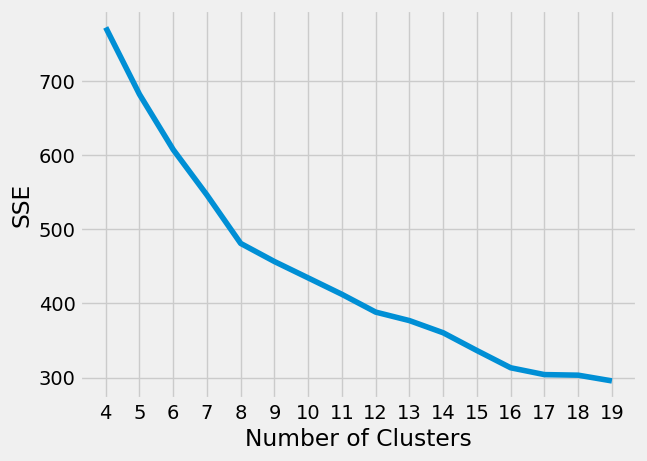

In [16]:
# Elbow curve to find optimal K 
kmeans_kwargs = {
    "init": "random",
    "n_init": 30,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
silhouette_avg = {}
start_kmeans = 4
end_kmeans = 20

for k in range(start_kmeans, end_kmeans):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    cluster_labels = kmeans.fit_predict(data)
    sse.append(kmeans.inertia_)
    silhouette_avg[k] = silhouette_score(data, cluster_labels)
    # print(k,silhouette_score(data, cluster_labels))
    

print(silhouette_avg)

plt.style.use("fivethirtyeight")
plt.plot(range(start_kmeans, end_kmeans), sse)
plt.xticks(range(start_kmeans, end_kmeans))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Plot data

In [17]:
# 9 categorías de zonificación

kmeans = KMeans(
    init="random",
    n_clusters=8,
    n_init=30,
    max_iter=300,
    random_state=42
)
clusters = kmeans.fit_predict(data) 
clusters

array([5, 5, 5, 5, 5, 5, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6,
       6, 1, 6, 6, 1, 6, 5, 0, 5, 2, 0, 0, 2, 4, 4, 4, 5, 5, 5, 2, 2, 4,
       4, 4, 4, 2, 4, 2, 5, 5, 5, 2, 0, 4, 4, 5, 5, 2, 4, 1, 4, 2, 2, 2,
       5, 2, 2, 5, 4, 4, 4, 2, 5, 1, 6, 6, 1, 1, 6, 6, 4, 4, 4, 4, 7, 7,
       7, 7, 7, 3, 3, 3, 7, 1, 1, 1, 1, 1, 1, 7, 1, 7, 7, 7, 1, 1, 1, 7,
       1, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0], dtype=int32)

<AxesSubplot: >

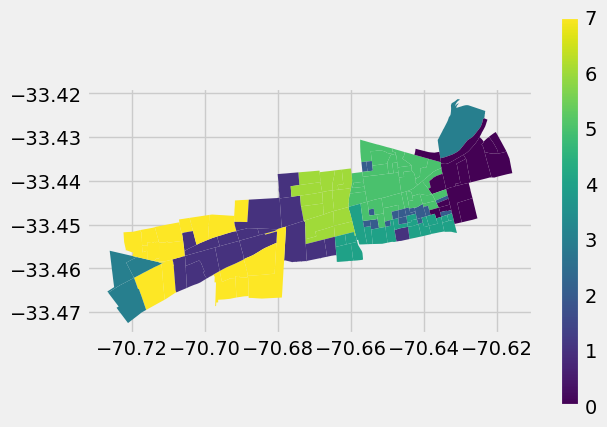

In [18]:
gdf['cluster'] = clusters
gdf.plot('cluster', legend=True)

Statistics

In [19]:
col_cluster = col_analysis
col_cluster.append('cluster')
col_cluster = list(set(col_cluster))

for c in gdf[col_cluster].columns:
    if gdf[c].dtypes == 'object':
        gdf[c] =  gdf[c].astype('float64')

In [20]:
gdf[col_cluster].groupby('cluster').mean()

,environmental_impact,dens_pobha,prc_hg_,prc_dmy,pr_JHES,working,learning,caring,supplying,ismtpn,living,prc_OcA,prc_cn_,enjoying,hqsl,wellbeing,sociability
cluster,,,,,,,,,,,,,,,,,
0,40.262140,171.712059,0.730131,0.100561,0.795529,6.231175,3.359116,6.892016,6.573844,0.752123,4.485283,0.841018,0.175382,6.914349,34.455784,36.870184,22.701191
1,28.987203,169.750074,0.654312,0.070245,0.465088,4.185284,4.781915,3.580285,5.265125,0.626079,3.884398,0.550610,0.278021,4.849196,26.546204,28.803420,21.059448
2,37.638222,1003.845556,0.806039,0.030426,0.795162,5.485615,4.865671,6.626772,7.573298,0.743106,5.830362,0.754193,0.164020,7.517250,37.898967,40.790913,29.750793
3,23.075858,78.241604,0.481514,0.076151,0.619853,2.361246,1.079908,2.173800,1.858771,0.685490,1.259514,0.890037,0.444552,2.888585,11.621825,10.594218,8.542025
4,33.150790,394.669466,0.768324,0.039950,0.771424,4.784799,4.630127,5.239975,6.448374,0.736988,4.028840,0.735755,0.192225,5.761678,30.893792,33.298684,22.757373
5,41.329933,309.824923,0.779125,0.076395,0.732456,6.756539,4.814225,6.657688,7.793734,0.727191,6.342910,0.730285,0.147566,8.569868,40.934965,43.127718,34.644641
6,37.024836,176.856135,0.675769,0.084780,0.603305,5.756015,6.247896,5.040772,7.167434,0.680117,5.699866,0.645583,0.245479,6.505078,36.417061,38.983589,28.118693
7,26.262963,119.074605,0.519872,0.106161,0.236506,2.625075,3.086947,2.627872,3.398661,0.533397,2.772392,0.486839,0.376116,3.053304,17.564251,16.678112,16.614839


In [21]:
gdf[col_cluster].groupby('cluster').std()

,environmental_impact,dens_pobha,prc_hg_,prc_dmy,pr_JHES,working,learning,caring,supplying,ismtpn,living,prc_OcA,prc_cn_,enjoying,hqsl,wellbeing,sociability
cluster,,,,,,,,,,,,,,,,,
0,1.398258,122.235841,0.047708,0.022555,0.043473,0.343456,0.479769,0.615775,0.805289,0.017774,0.917701,0.106061,0.032176,1.244557,1.947106,2.395400,3.127313
1,5.398680,74.749953,0.066498,0.032409,0.117318,1.306921,0.583237,0.722137,1.021304,0.040200,0.936075,0.107447,0.042382,0.955718,3.849353,5.894352,1.843540
2,3.107097,290.074574,0.027993,0.011832,0.055755,0.729466,0.535073,0.725749,0.427444,0.018855,1.156606,0.045376,0.021154,0.970490,2.255419,2.213834,4.046795
3,2.981279,39.341848,0.152011,0.041725,0.103935,0.686820,0.609358,0.886888,0.649575,0.039709,0.445425,0.253319,0.189625,1.121588,3.976997,4.731077,1.974106
4,4.756036,162.312377,0.040204,0.015682,0.037949,0.596266,0.625242,1.374960,0.951518,0.013335,0.915264,0.051057,0.032653,0.926849,3.017369,3.910044,3.098690
5,1.799170,191.140579,0.035407,0.029050,0.079472,0.525557,0.629768,0.615577,0.387844,0.027052,0.797581,0.076428,0.034466,0.389335,1.709208,1.416536,3.829588
6,1.998848,52.944743,0.033956,0.017663,0.091472,0.324278,0.740495,0.494650,0.498140,0.030184,0.660399,0.076441,0.039442,0.590526,2.478179,2.434997,3.208597
7,6.088628,50.040805,0.049337,0.032714,0.115982,0.414709,0.929270,0.580184,0.910388,0.052087,1.013609,0.106597,0.048646,0.826700,2.465184,3.031153,2.852203


In [22]:
gdf[col_cluster].groupby('cluster').count()

,environmental_impact,dens_pobha,prc_hg_,prc_dmy,pr_JHES,working,learning,caring,supplying,ismtpn,living,prc_OcA,prc_cn_,enjoying,hqsl,wellbeing,sociability
cluster,,,,,,,,,,,,,,,,,
0,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
1,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
2,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
4,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19
5,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28
6,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
7,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16


In [23]:
gdf_filter = gdf.drop(columns=['gse_dom','geocodigo','GEOCODI','geometry']).groupby(['gse_prom','cluster']).mean().sort_values(by='ismtpn', ascending=False)[['ismtpn','dens_pobha','prc_hg_',
                  'prc_cn_','prc_dmy','pr_JHES','prc_OcA',
                  'sociability','wellbeing','environmental_impact',
                  'supplying','caring','living',
                  'enjoying','working','learning',
                  'hqsl']]
gdf_filter

ismtpn   dens_pobha   prc_hg_   prc_cn_   prc_dmy  \
gse_prom cluster                                                        
C1       0        0.773139   101.114000  0.726405  0.184402  0.098073   
C2       0        0.746391   190.966075  0.731147  0.172922  0.101239   
         2        0.743106  1003.845556  0.806039  0.164020  0.030426   
         4        0.736988   394.669466  0.768324  0.192225  0.039950   
         5        0.729870   319.713303  0.781568  0.146882  0.074531   
         3        0.718828    77.857605  0.568940  0.341998  0.092323   
         1        0.698567   292.527019  0.647222  0.261806  0.093750   
         6        0.698100   197.412811  0.675659  0.243906  0.084653   
C3       5        0.654874    42.838673  0.713163  0.166012  0.126719   
         3        0.652152    78.625603  0.394088  0.547106  0.059979   
         6        0.651346   143.965453  0.675945  0.247995  0.084983   
         1        0.634890   177.923512  0.669206  0.273609  0.059650   
         7        0.631969   143.085210  0.539768  0.315630  0.144602   
D        1        0.563734    93.406195  0.592132  0.302545  0.108325   
         7        0.519315   115.644519  0.517030  0.384757  0.100669   

                   pr_JHES   prc_OcA  sociability  wellbeing  \
gse_prom cluster                                               
C1       0        0.840669  0.884489    22.114180  35.373803   
C2       0        0.783219  0.829162    22.861285  37.278288   
         2        0.795162  0.754193    29.750793  40.790913   
         4        0.771424  0.735755    22.757373  33.298684   
         5        0.740557  0.734922    34.464756  43.064040   
         3        0.708438  0.804332     7.444062  11.629150   
         1        0.649306  0.698611    21.626505  29.756191   
         6        0.653878  0.682808    28.163172  38.182181   
C3       5        0.513752  0.605108    39.501532  44.847024   
         3        0.531268  0.975742     9.639989   9.559285   
         6        0.522388  0.586022    28.047525  40.265843   
         1        0.494880  0.570391    21.006381  27.352353   
         7        0.467597  0.644072    17.485301  18.676469   
D        1        0.274582  0.415558    21.100390  34.773787   
         7        0.203493  0.464377    16.490487  16.392632   

                  environmental_impact  supplying    caring    living  \
gse_prom cluster                                                        
C1       0                   38.815247   6.224351  6.889281  5.341766   
C2       0                   40.656747   6.669160  6.892762  4.251697   
         2                   37.638222   7.573298  6.626772  5.830362   
         4                   33.150790   6.448374  5.239975  4.028840   
         5                   41.305516   7.780384  6.645742  6.334361   
         3                   21.972424   1.797814  2.429908  1.207172   
         1                   37.440660   5.932489  3.216950  3.884938   
         6                   37.489652   7.033499  4.925502  5.646772   
C3       5                   41.989185   8.154187  6.980214  6.573751   
         3                   24.179291   1.919728  1.917693  1.311857   
         6                   36.281131   7.381732  5.225205  5.784817   
         1                   27.867877   5.013731  3.540821  3.650372   
         7                   26.555292   3.835729  2.744002  2.693116   
D        1                   31.019797   6.132041  3.872409  4.898331   
         7                   26.221202   3.336223  2.611282  2.783717   

                  enjoying   working  learning       hqsl  
gse_prom cluster                                           
C1       0        5.812693  6.179821  2.783892  33.231804  
C2       0        7.214800  6.245181  3.515996  34.789596  
         2        7.517250  5.485615  4.865671  37.898967  
         4        5.761678  4.784799  4.630127  30.893792  
         5        8.561988  6.730367  4.809778  40.862620  
         3        3.216387 

In [24]:
gdf.drop(columns=['gse_dom','geocodigo','GEOCODI','geometry']).groupby(['gse_prom','cluster']).count().sort_values(by='ismtpn', ascending=False)[['ismtpn','dens_pobha','prc_hg_',
                  'prc_cn_','prc_dmy','pr_JHES','prc_OcA',
                  'sociability','wellbeing','environmental_impact',
                  'supplying','caring','living',
                  'enjoying','working','learning',
                  'hqsl']]

ismtpn  dens_pobha  prc_hg_  prc_cn_  prc_dmy  pr_JHES  \
gse_prom cluster                                                           
C2       5            27          27       27       27       27       27   
         4            19          19       19       19       19       19   
         2            16          16       16       16       16       16   
D        7            14          14       14       14       14       14   
C3       1            13          13       13       13       13       13   
C2       0            11          11       11       11       11       11   
         6             8           8        8        8        8        8   
C3       6             5           5        5        5        5        5   
C1       0             3           3        3        3        3        3   
D        1             3           3        3        3        3        3   
C2       3             2           2        2        2        2        2   
C3       3             2           2        2        2        2        2   
         7             2           2        2        2        2        2   
C2       1             1           1        1        1        1        1   
C3       5             1           1        1        1        1        1   

                  prc_OcA  sociability  wellbeing  environmental_impact  \
gse_prom cluster                                                          
C2       5             27           27         27                    27   
         4             19           19         19                    19   
         2             16           16         16                    16   
D        7             14           14         14                    14   
C3       1             13           13         13                    13   
C2       0             11           11         11                    11   
         6              8            8          8                     8   
C3       6              5            5          5                     5   
C1       0              3            3          3                     3   
D        1              3            3          3                     3   
C2       3              2            2          2                     2   
C3       3              2            2          2                     2   
         7              2            2          2                     2   
C2       1              1            1          1                     1   
C3       5              1            1          1                     1   

                  supplying  caring  living  enjoying  working  learning  hqsl  
gse_prom cluster                                                                
C2       5               27      27      27        27       27        27    27  
         4               19      19      19        19       19        19    19  
         2               16      16      16        16       16        16    16  
D        7               14      14      14        14       14        14    14  
C3       1               13      13      13        13       13        13    13  
C2       0               11      11      11        11       11        11    11  
         6                8       8       8         8        8         8     8  
C3       6                5       5       5         5        5         5     5  
C1       0                3       3       3         3        3         3     3  
D        1                3       3       3         3        3         3     3  
C2       3                2       2       2         2        2         2     2  
C3       3                2       2       2         2        2         2     2  
         7                2       2       2         2        2         2     2  
C2       1                1       1       1         1        1         1     1  
C3       5                1       1       1         1        1         1     1

In [25]:
import seaborn as sns

In [26]:
gdf_plot = gdf_filter.copy()
for c in gdf_plot.columns:
    if gdf_plot[c].mean() < 1:
        gdf_plot[c] = gdf_plot[c] * 10
gdf_plot

ismtpn   dens_pobha   prc_hg_   prc_cn_   prc_dmy  \
gse_prom cluster                                                        
C1       0        7.731391   101.114000  7.264048  1.844017  0.980734   
C2       0        7.463909   190.966075  7.311469  1.729220  1.012389   
         2        7.431064  1003.845556  8.060392  1.640199  0.304259   
         4        7.369879   394.669466  7.683237  1.922249  0.399498   
         5        7.298696   319.713303  7.815675  1.468823  0.745311   
         3        7.188277    77.857605  5.689395  3.419977  0.923228   
         1        6.985667   292.527019  6.472222  2.618056  0.937500   
         6        6.980998   197.412811  6.756586  2.439059  0.846527   
C3       5        6.548736    42.838673  7.131631  1.660118  1.267191   
         3        6.521523    78.625603  3.940878  5.471060  0.599787   
         6        6.513455   143.965453  6.759447  2.479952  0.849834   
         1        6.348904   177.923512  6.692062  2.736086  0.596497   
         7        6.319687   143.085210  5.397676  3.156301  1.446024   
D        1        5.637339    93.406195  5.921322  3.025455  1.083252   
         7        5.193153   115.644519  5.170297  3.847567  1.006690   

                   pr_JHES   prc_OcA  sociability  wellbeing  \
gse_prom cluster                                               
C1       0        8.406687  8.844888    22.114180  35.373803   
C2       0        7.832187  8.291623    22.861285  37.278288   
         2        7.951619  7.541928    29.750793  40.790913   
         4        7.714237  7.357554    22.757373  33.298684   
         5        7.405565  7.349217    34.464756  43.064040   
         3        7.084380  8.043325     7.444062  11.629150   
         1        6.493056  6.986111    21.626505  29.756191   
         6        6.538785  6.828084    28.163172  38.182181   
C3       5        5.137525  6.051081    39.501532  44.847024   
         3        5.312677  9.757418     9.639989   9.559285   
         6        5.223877  5.860217    28.047525  40.265843   
         1        4.948800  5.703907    21.006381  27.352353   
         7        4.675973  6.440718    17.485301  18.676469   
D        1        2.745822  4.155576    21.100390  34.773787   
         7        2.034925  4.643767    16.490487  16.392632   

                  environmental_impact  supplying    caring    living  \
gse_prom cluster                                                        
C1       0                   38.815247   6.224351  6.889281  5.341766   
C2       0                   40.656747   6.669160  6.892762  4.251697   
         2                   37.638222   7.573298  6.626772  5.830362   
         4                   33.150790   6.448374  5.239975  4.028840   
         5                   41.305516   7.780384  6.645742  6.334361   
         3                   21.972424   1.797814  2.429908  1.207172   
         1                   37.440660   5.932489  3.216950  3.884938   
         6                   37.489652   7.033499  4.925502  5.646772   
C3       5                   41.989185   8.154187  6.980214  6.573751   
         3                   24.179291   1.919728  1.917693  1.311857   
         6                   36.281131   7.381732  5.225205  5.784817   
         1                   27.867877   5.013731  3.540821  3.650372   
         7                   26.555292   3.835729  2.744002  2.693116   
D        1                   31.019797   6.132041  3.872409  4.898331   
         7                   26.221202   3.336223  2.611282  2.783717   

                  enjoying   working  learning       hqsl  
gse_prom cluster                                           
C1       0        5.812693  6.179821  2.783892  33.231804  
C2       0        7.214800  6.245181  3.515996  34.789596  
         2        7.517250  5.485615  4.865671  37.898967  
         4        5.761678  4.784799  4.630127  30.893792  
         5        8.561988  6.730367  4.809778  40.862620  
         3        3.216387 

In [27]:
gdf_plot = gdf_filter.copy()
for c in gdf_plot.columns:
    if c != 'cluster':
        gdf_plot[c] = (gdf_plot[c] - gdf_plot[c].mean())/(gdf_plot[c].std())
gdf_plot

ismtpn  dens_pobha   prc_hg_   prc_cn_   prc_dmy  \
gse_prom cluster                                                       
C1       0        1.354095   -0.522049  0.642661 -0.738486  0.374718   
C2       0        0.977806   -0.143131  0.684622 -0.846271  0.478632   
         2        0.931600    3.284895  1.347308 -0.929855 -1.845889   
         4        0.845526    0.715915  1.013582 -0.665032 -1.533256   
         5        0.745387    0.399814  1.130769 -1.090763 -0.398084   
         3        0.590051   -0.620125 -0.750674  0.741217  0.185948   
         1        0.305022    0.285166 -0.057988 -0.011724  0.232799   
         6        0.298453   -0.115944  0.193632 -0.179788 -0.065830   
C3       5       -0.309646   -0.767805  0.525491 -0.911153  1.315047   
         3       -0.347929   -0.616886 -2.297852  2.667023 -0.875783   
         6       -0.359279   -0.341339  0.196164 -0.141393 -0.054975   
         1       -0.590768   -0.198133  0.136538  0.099097 -0.886585   
         7       -0.631870   -0.345051 -1.008802  0.493646  1.902088   
D        1       -1.591787   -0.554554 -0.545453  0.370792  0.711247   
         7       -2.216661   -0.460772 -1.209999  1.142690  0.459924   

                   pr_JHES   prc_OcA  sociability  wellbeing  \
gse_prom cluster                                               
C1       0        1.283838  1.269077    -0.084532   0.400909   
C2       0        0.981509  0.903608     0.003664   0.566015   
         2        1.044360  0.408385     0.816968   0.870538   
         4        0.919438  0.286593    -0.008603   0.221009   
         5        0.757001  0.281086     1.373449   1.067604   
         3        0.587978  0.739591    -1.816334  -1.657603   
         1        0.276796  0.041231    -0.142101  -0.086103   
         6        0.300861 -0.063157     0.629550   0.644377   
C3       5       -0.436548 -0.576419     1.968039   1.222177   
         3       -0.344374  1.871863    -1.557105  -1.837047   
         6       -0.391105 -0.702498     0.615898   0.825017   
         1       -0.535863 -0.805750    -0.215307  -0.294500   
         7       -0.679437 -0.319038    -0.630969  -1.046645   
D        1       -1.695173 -1.828526    -0.204209   0.348891   
         7       -2.069280 -1.506044    -0.748406  -1.244639   

                  environmental_impact  supplying    caring    living  \
gse_prom cluster                                                        
C1       0                    0.792953   0.262928  1.206635  0.618436   
C2       0                    1.067963   0.478640  1.208512 -0.017358   
         2                    0.617176   0.917107  1.065146  0.903415   
         4                   -0.052978   0.371569  0.317682 -0.147342   
         5                    1.164850   1.017535  1.075371  1.197378   
         3                   -1.722356  -1.883747 -1.196905 -1.793110   
         1                    0.587672   0.121388 -0.772700 -0.231275   
         6                    0.594988   0.655328  0.148185  0.796334   
C3       5                    1.266949   1.198812  1.255647  1.337004   
         3                   -1.392782  -1.824624 -1.472982 -1.732052   
         6                    0.414508   0.824206  0.309722  0.876850   
         1                   -0.841929  -0.324169 -0.598138 -0.368087   
         7                   -1.037950  -0.895448 -1.027612 -0.926417   
D        1                   -0.371220   0.218161 -0.419417  0.359798   
         7                   -1.087843  -1.137687 -1.099147 -0.873573   

                  enjoying   working  learning      hqsl  
gse_prom cluster                                          
C1       0        0.062785  0.802305 -0.790299  0.400535  
C2       0        0.785787  0.841437 -0.327182  0.554457  
         2        0.941747  0.386680  0.526602  0.861686  
         4        0.036479 -0.032903  0.377601  0.169522  
         5        1.480470  1.131921  0.491245  1.154516  
         3       -1.276011 -1.433166 -1.894850 -1.6

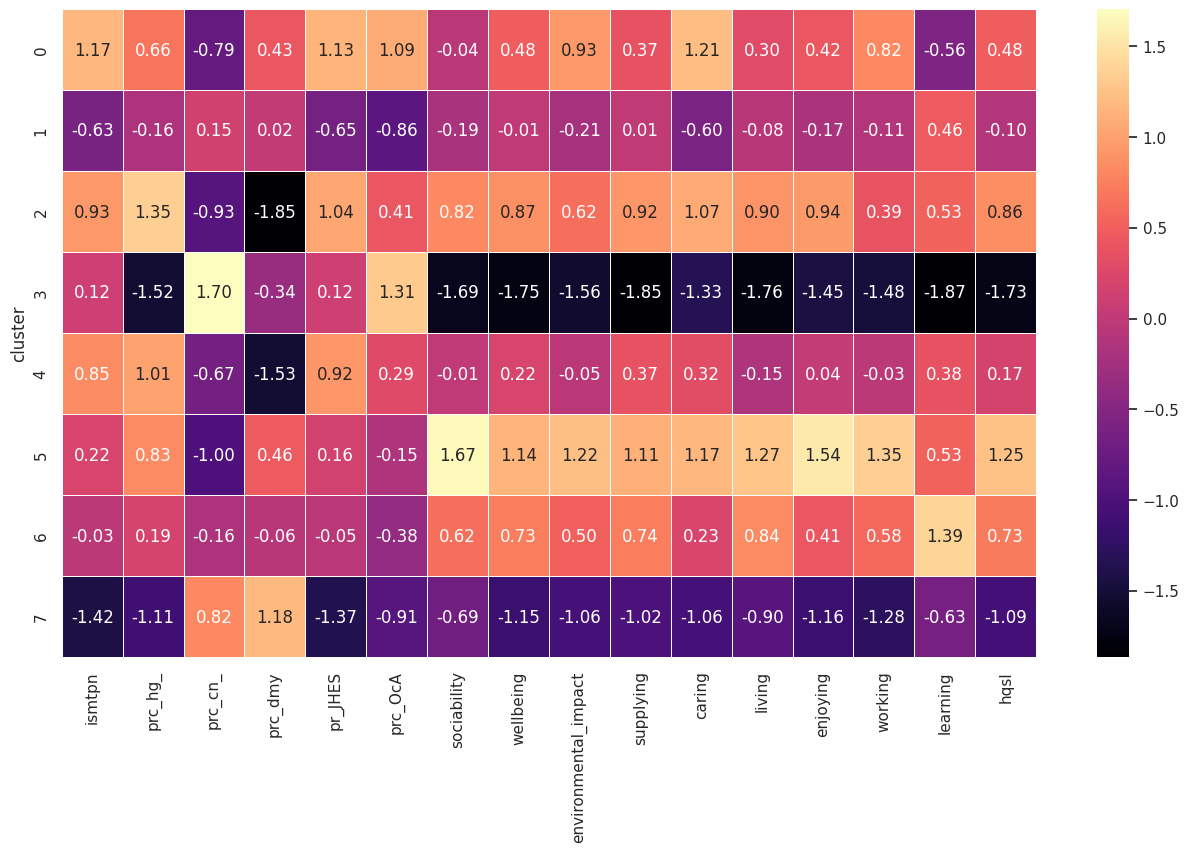

In [28]:
# sns.heatmap(gdf[col_cluster].drop(columns=['dens_pobha']).groupby('cluster').mean(), 
#             annot=False,fmt=".2f", linewidth=.5, cmap="crest")
sns.set (rc = {'figure.figsize':(14,8)})

sns.heatmap(gdf_plot.drop(columns=['dens_pobha']).groupby('cluster').mean(), 
            annot=True,fmt=".2f", linewidth=.5, cmap="magma")

plt.savefig(f'../../../output/figures/santiago/polar_plots/{speed_name}/Clusters_Statistical_Behaviour.svg')

In [29]:
gdf_output = gdf[['geocodigo','cluster','geometry']].copy()

if save:
    table = f'santiago_{area_of_analysis}cluster_{speed_name}_kmh'
    schema = 'projects_research'
    aup.gdf_to_db_slow(gdf_output, table, schema, if_exists='append')
if save_local:
    gdf_output.to_file(grl_dir + f'alameda_{area_of_analysis}cluster_{speed_name}_kmh_v2.geojson')